# stock prediction
reference: https://towardsdatascience.com/predicting-apple-stock-in-times-of-coronavirus-ca434bd2f788

In [1]:
import json
import OpenBlender
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)
pd.set_option('max_colwidth',200)

In [3]:
stock_data_path = "../data/stock_data/apple_stock.json"
vectorized_news_data_path = "../data/stock_data/vectorized_news.json"

In [4]:
# read stock data
stock_data = pd.read_json(stock_data_path, convert_dates=False, convert_axes=False).sort_values("timestamp", ascending=False)
stock_data.reset_index(drop=True, inplace=True)

In [5]:
stock_data

,volume,timestamp,price,high,low,open,change
0,51.05M,1.585328e+09,247.74,255.85,247.21,252.14,-4.14%
1,75.90M,1.585240e+09,245.52,257.94,244.33,250.80,-0.55%
2,75.90M,1.585217e+09,245.52,257.94,244.33,250.80,-0.55%
3,75.90M,1.585196e+09,245.52,257.94,244.33,250.80,-0.55%
4,71.88M,1.585174e+09,246.88,246.88,234.42,237.00,10.03%
...,...,...,...,...,...,...,...
781,33.56M,1.483978e+09,118.99,119.43,117.94,117.95,0.92%
782,31.75M,1.483718e+09,117.91,118.16,116.47,116.78,1.11%
783,22.19M,1.483632e+09,116.61,116.86,115.81,115.92,0.51%
784,21.12M,1.483546e+09,116.02,116.51,115.75,115.85,-0.11%


In [6]:
# read vectorized news data
vectorized_data = pd.read_json(vectorized_news_data_path, convert_dates=False, convert_axes=False).sort_values("timestamp", ascending=False)
# vectorized_data.columns = vectorized_data.columns.str.replace("5e46c8cf9516297ce1ada712_", "")
vectorized_data.reset_index(drop=True, inplace=True)

In [7]:
vectorized_data.columns[~vectorized_data.columns.str.startswith("5e4")]

Index(['change', 'open', 'price', 'low', 'count_agg', 'timestamp', 'high',
       'ind', 'lag-1_change'],
      dtype='object')

In [8]:
vectorized_data["ind"]

0       10
1        9
2        8
3        7
4        6
        ..
1161     4
1162     3
1163     2
1164     1
1165     0
Name: ind, Length: 1166, dtype: int64

In [9]:
# Where ‘change’ decreased more than 0.5%
vectorized_data["negative_poc"] = [1 if val < 0.5 else 0 for val in vectorized_data["lag-1_change"]]
# Where ‘change’ increased more than 0.5%
vectorized_data["positive_poc"] = [1 if val > 0.5 else 0 for val in vectorized_data["lag-1_change"]]

In [10]:
# First we create separeate dataframes for positive and negative
df_positive = vectorized_data.select_dtypes(["number"]).drop(columns=["negative_poc"])
df_negative = vectorized_data.select_dtypes(["number"]).drop(columns=["positive_poc"])

In [11]:
df_positive

,5e46c8cf9516297ce1ada712_votes,5e46c8cf9516297ce1ada712_support,5e46c8cf9516297ce1ada712_treating,5e46c8cf9516297ce1ada712_gen,5e46c8cf9516297ce1ada712_international,5e46c8cf9516297ce1ada712_link,5e46c8cf9516297ce1ada712_voter,5e46c8cf9516297ce1ada712_matt,5e46c8cf9516297ce1ada712_fun,5e46c8cf9516297ce1ada712_300,...,5e46c8cf9516297ce1ada712_egypts,5e46c8cf9516297ce1ada712_india,5e46c8cf9516297ce1ada712_prospect,5e46c8cf9516297ce1ada712_gaza,5e46c8cf9516297ce1ada712_urban,5e46c8cf9516297ce1ada712_fourth quarter,5e46c8cf9516297ce1ada712_cave,5e46c8cf9516297ce1ada712_brett,lag-1_change,positive_poc
0,0,0,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,0
1,0,48,0,3,0,0,0,0,0,0,...,0,0,13,0,0,0,0,0,-2.943333,0
2,0,9,0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,-2.943333,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-4.140000,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.550000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1.110000,1
1162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.510000,1
1163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.110000,0
1164,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.280000,0


In [38]:
df_positive[0:450]["positive_poc"].values

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [35]:
def getMetricsFromModel(target, df):
    # Create train/test sets
    X = df.loc[:, df.columns != target]
    X = X.loc[:, X.columns != 'lag-1_change'].values
    y = df.loc[:,[target]].values
    
    # Create X and y.
    div = int(round(len(X) * 0.89))
    
    real_values = df[div:].loc[:,['lag-1_change']].values
    
    X_train = X[:div]
    y_train = y[:div]
    X_test = X[div:]
    y_test = y[div:]
    
    # Perform ML
    rf = RandomForestRegressor(n_estimators=1000, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Get Metrics
    auc = metrics.roc_auc_score(y_test, y_pred)
    print("AUC score: {}".format(auc))
    preds = [1 if val > 0.6 else 0 for val in y_pred]
    print("Confusion Matrix:")
    conf_matrix = metrics.confusion_matrix(y_test, preds)
    print(metrics.confusion_matrix(y_test, preds))
    
    acc = metrics.accuracy_score(y_test, preds)
    print("Acurracy: {}".format(acc))
    
    df_compare = pd.DataFrame({"real_values" : real_values.ravel(), "y_test" : y_test.ravel(), "preds" : y_pred})
    
    return auc, conf_matrix, acc, df_compare

In [36]:
df_compare_acc = None
for i in range(0, vectorized_data.shape[0] - 450, 50):
    print(i, i + 450)
    print("-----------------------------")
    auc, conf_matrix, acc, df_compare_p = getMetricsFromModel("positive_poc", df_positive[i : i + 450])
    auc, conf_matrix, acc, df_compare_n = getMetricsFromModel("negative_poc", df_negative[i : i + 450])
    df_compare = df_compare_p[["y_test", "real_values"]]
    df_compare.rename(columns={"y_test":"price_rised_5"}, inplace=True)
    df_compare["F_p"] = df_compare_p["preds"]
    df_compare["price_dropped_5"] = df_compare_n["y_test"]
    df_compare["F_n"] = df_compare_n["preds"]
    if df_compare_acc is None:
        df_compare_acc = df_compare
    else:
        df_compare_acc = pd.concat([df_compare_acc, df_compare], ignore_index=True)

0 450
-----------------------------
AUC score: 0.5793226381461676
Confusion Matrix:
[[22 11]
 [11  6]]
Acurracy: 0.56
AUC score: 0.6042780748663101
Confusion Matrix:
[[17  0]
 [32  1]]
Acurracy: 0.36
50 500
-----------------------------
AUC score: 0.5717255717255717
Confusion Matrix:
[[34  3]
 [ 9  4]]
Acurracy: 0.76
AUC score: 0.603950103950104
Confusion Matrix:
[[ 5  8]
 [10 27]]
Acurracy: 0.64
100 550
-----------------------------
AUC score: 0.6417069243156199
Confusion Matrix:
[[25  2]
 [17  6]]
Acurracy: 0.62
AUC score: 0.6314102564102564
Confusion Matrix:
[[14 10]
 [12 14]]
Acurracy: 0.56
150 600
-----------------------------
AUC score: 0.7826825127334465
Confusion Matrix:
[[29  2]
 [15  4]]
Acurracy: 0.66
AUC score: 0.7835314091680815
Confusion Matrix:
[[16  3]
 [13 18]]
Acurracy: 0.68
200 650
-----------------------------
AUC score: 0.6656746031746031
Confusion Matrix:
[[35  1]
 [11  3]]
Acurracy: 0.76
AUC score: 0.6676587301587302
Confusion Matrix:
[[ 6  8]
 [ 8 28]]
Acurracy:

In [39]:
# This function will run a simulation on all the tested data 
# given an invested "starting_sum" and will return its
# trayectory.
def runSimulation(include_pos, includle_neg, starting_sum): 
    sum_lst = []
    actual_sum = starting_sum
    for index, row in df_compare_acc.iterrows():
        if row["F_p"] > 0.5 and row["F_n"] < 0.5 and include_pos:
            actual_sum = actual_sum + (actual_sum * (row["real_values"] / 100))
        if row["F_n"] > 0.5 and row["F_p"] < 0.5 and includle_neg:
            actual_sum = actual_sum - (actual_sum * (row["real_values"] / 100))
        sum_lst.append(actual_sum)
    return sum_lst

2735.6158559614055


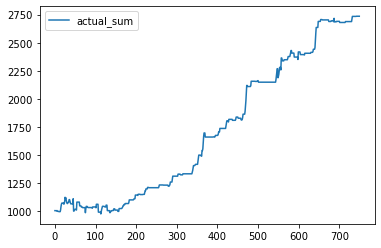

In [40]:
sum_lst = runSimulation(True, False, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])

2095.2845167661358


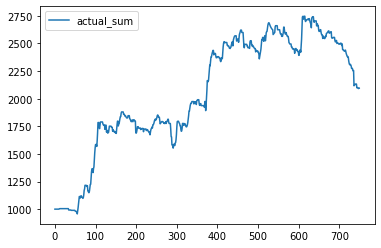

In [41]:
sum_lst = runSimulation(False, True, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])

5731.8935468158725


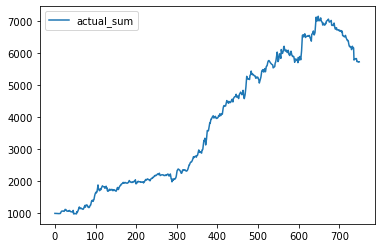

In [42]:
sum_lst = runSimulation(True, True, 1000)
df_compare_acc["actual_sum"] = sum_lst
print(sum_lst[len(sum_lst)-1])
df_compare_acc.plot(y = ["actual_sum"])